In [1]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *

sim_name = f"SunMod_1k"
sim_folder = f"sim_output/{sim_name}"

fig_folder = f"figures_local/{sim_name}"
Cl_folder = f"Shared/Cls"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)

# Solar Gravity implementation

## Sun gravity function

In [3]:
# Compute gradient of sun.
init_dis = 1*Params.AU
x_i = np.array([init_dis, 0., 0.])
eps = 696_340*Params.km  # solar radius in numerical units
grad_sun = SimExec.sun_gravity(x_i, eps, jnp.array([0,0,0]))
ic(grad_sun)

# Solar acceleration, should be around ~6 millimeter/s^2 according to internet
grad_sun /= (Params.m/1e3/Params.s**2)
ic(grad_sun)

ic| grad_sun: Array([-1.30194237e-26, -0.00000000e+00, -0.00000000e+00], dtype=float64)
ic| grad_sun: Array([-5.9298908, -0.       , -0.       ], dtype=float64)


Array([-5.9298908, -0.       , -0.       ], dtype=float64)

In [14]:
z_int_steps = jnp.load(f'{sim_folder}/z_int_steps_1year.npy')
s_int_steps = jnp.load(f'{sim_folder}/s_int_steps_1year.npy')
z_test = 0.
idx = jnp.abs(z_int_steps - z_test).argmin()

# Load gravity 
halo_ID = 53
data_dir = f"Data/halo_grids"
dPsi_grids, cell_grids, cell_gens = SimGrid.grid_data(halo_ID, data_dir)
snaps_GRID_L = jnp.load(f'{data_dir}/snaps_GRID_L_halo1.npy')

dPsi_grid = dPsi_grids[idx]
cell_grid = cell_grids[idx]
cell_gens = cell_gens[idx]
snap_GRID_L = snaps_GRID_L[idx]

x_i = jnp.array([8.1, 0., 0.])*Params.kpc
cell_idx, *_ = SimExec.nu_in_which_cell(
    x_i, cell_grid, cell_gens, snap_GRID_L)
grad_tot = dPsi_grid[cell_idx, :]
ic(grad_tot)
print("...")

ic| grad_tot: Array([0., 0., 0.], dtype=float64)


...


# Solar dipole implementation

## Planck (2018) values

In [15]:
v_Sun_CMB = 369.82*Params.km/Params.s  # velocity of Sun w.r.t. CMB
l_Sun_CMB = 264.021
b_Sun_CMB = 48.253

vec_Sun_CNB = SimUtil.Galactic_velocity_to_Cartesian_vector(
    v_Sun_CMB, l_Sun_CMB, b_Sun_CMB)/(Params.km/Params.s)

mag_Sun_CNB = jnp.linalg.norm(vec_Sun_CNB)

ic(vec_Sun_CNB)
ic(mag_Sun_CNB)
ic(vec_Sun_CNB/mag_Sun_CNB)
print("...")

ic| vec_Sun_CNB: Array([ -25.64952885, -244.90238947,  275.91983202], dtype=float64)
ic| mag_Sun_CNB: Array(369.82, dtype=float64)
ic| vec_Sun_CNB/mag_Sun_CNB: Array([-0.06935679, -0.66222051,  0.74609224], dtype=float64)


...


## Dipole maps for each day of the year: Earth's frame

In [16]:
def calculate_sun_and_earth_position_and_velocity(year):
    # Define the Galactic Center coordinates
    gc = SkyCoord(l=0*apu.degree, b=0*apu.degree, frame='galactic')
    
    # Sun's velocity w.r.t. CMB in galactic coordinates (km/s)
    sun_vel_cmb_gal = np.array([-0.06935679, -0.66222051, 0.74609224]) * 369.82
    
    # Create lists to store the Sun's positions and velocities, and Earth's velocities
    sun_positions = []
    sun_velocities_cmb = []
    earth_velocities_cmb = []
    
    for day in range(365, 0, -1):  # Loop backwards through each day of the year
        # Create Time objects for the current day and the next day at noon UTC
        time = Time(f'{year}-12-31 12:00:00') - (365 - day) * apu.day
        time_next = time + 1 * apu.day
        
        # Get the Earth's position in ICRS coordinates at current and next day (in km)
        earth_icrs = SkyCoord(get_body_barycentric('earth', time), frame='icrs')
        earth_icrs_next = SkyCoord(get_body_barycentric('earth', time_next), frame='icrs')
        
        # Calculate Earth's velocity in ICRS frame (km/s)
        earth_vel_icrs = (earth_icrs_next.cartesian.xyz - earth_icrs.cartesian.xyz).to(apu.km).value / apu.day.to(apu.s)
        
        # Get the Sun's position in GCRS coordinates (relative to Earth) in km
        sun_gcrs = SkyCoord(get_body_barycentric('sun', time), frame='icrs').transform_to(GCRS(obstime=time))
        sun_vector = sun_gcrs.cartesian.xyz.to(apu.km).value
        
        # Transform the Galactic Center to GCRS
        gc_gcrs = gc.transform_to(GCRS(obstime=time))
        
        # Calculate the unit vector pointing from Earth to Galactic Center
        gc_vector = gc_gcrs.cartesian.xyz.value
        gc_unit_vector = gc_vector / np.linalg.norm(gc_vector)
        
        # Define the new coordinate system
        x_axis = gc_unit_vector
        z_axis = np.cross(x_axis, [0, 0, 1])
        z_axis = z_axis / np.linalg.norm(z_axis)
        y_axis = np.cross(z_axis, x_axis)
        
        # Create the rotation matrix
        rotation_matrix = np.column_stack((x_axis, y_axis, z_axis))
        
        # Rotate the Sun's position into the new coordinate system (km)
        sun_rotated = np.dot(rotation_matrix.T, sun_vector)
        
        # Rotate the Sun's velocity w.r.t. CMB into the new coordinate system (km/s)
        sun_vel_cmb_rotated = np.dot(rotation_matrix.T, sun_vel_cmb_gal)
        
        # Rotate Earth's velocity into the new coordinate system (km/s)
        earth_vel_rotated = np.dot(rotation_matrix.T, earth_vel_icrs)
        
        # Calculate Earth's velocity relative to CMB in the rotated frame (km/s)
        earth_vel_cmb_rotated = sun_vel_cmb_rotated + earth_vel_rotated
        
        # Append the rotated position and velocities to the lists
        sun_positions.append(sun_rotated)
        sun_velocities_cmb.append(sun_vel_cmb_rotated)
        earth_velocities_cmb.append(earth_vel_cmb_rotated)
    
    # note: sun_positions: km units ; velocities: km/s units
    return np.array(sun_positions), np.array(sun_velocities_cmb), np.array(earth_velocities_cmb)


def create_dipole_map(velocity_vector, simdata, args):
    
    # Get the theta and phi angles for each pixel
    theta, phi = hp.pix2ang(simdata.Nside, np.arange(simdata.Npix))
    
    # Convert velocity vector to spherical coordinates
    v_mag = np.linalg.norm(velocity_vector)
    v_theta = np.arccos(velocity_vector[2] / v_mag)
    v_phi = np.arctan2(velocity_vector[1], velocity_vector[0])
    
    # Calculate the dipole anisotropy
    cos_angle = np.sin(theta) * np.sin(v_theta) * np.cos(phi - v_phi) + np.cos(theta) * np.cos(v_theta)
    dipole = args.T_CNB * (1 + v_mag * cos_angle)
    
    return dipole


def create_neutrino_density_dipole_animation(year, simdata, Params, sim_folder, fps=2, dpi=100, day_step=5):
    # Get Sun and Earth velocities
    sun_positions, sun_velocities_cmb, earth_velocities_cmb = calculate_sun_and_earth_position_and_velocity(year)

    # Earth velocities in Earth-GC frame
    earth_vels = earth_velocities_cmb - sun_velocities_cmb

    # Convert velocities to km/s
    sun_velocities_cmb *= Params.km/Params.s
    earth_velocities_cmb *= Params.km/Params.s

    nu_ratios_l = []
    frames = []

    for day in range(1, 366, day_step):
        earth_vel_cmb = earth_velocities_cmb[day-1]
        
        # Compute temperature dipole map from combined velocity vector
        T_dipole_map = create_dipole_map(earth_vel_cmb, simdata, Params)

        # Convert to number density map
        N_dipole_map = 3*zeta(3) / (4*Params.Pi**2) * T_dipole_map**3

        # Get increase/decrease factor, i.e. ratio compared to LambdaCDM value
        nu_ratio = N_dipole_map/Params.N0
        nu_ratios_l.append(nu_ratio)

        # Create a new figure for each day
        fig = plt.figure(figsize=(12, 8))
        hp.mollview(
            nu_ratio, 
            title=f"Neutrino Density Dipole - Day {day}", 
            unit=r"$n_\nu / n_{\nu,0}$", 
            cmap="coolwarm",
            fig=fig
        )
        hp.graticule()

        # Save the figure to a buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=dpi)
        buf.seek(0)
        
        # Read the image and append to frames
        img = plt.imread(buf)
        frames.append(img)
        
        plt.close(fig)

    # Create the animation
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')
    im = ax.imshow(frames[0])

    def animate(i):
        im.set_array(frames[i])
        return [im]

    anim = FuncAnimation(fig, animate, frames=len(frames), interval=1000//fps, blit=True)

    # Save the animation
    anim.save(f"{sim_folder}/nu_density_dipole_animation.gif", writer='pillow', fps=fps)

    # Save the nu_ratios_l array
    jnp.save(f"{sim_folder}/nu_dens_dipole_factors.npy", jnp.array(nu_ratios_l))

    plt.close(fig)


# Usage
year = 2024
create_neutrino_density_dipole_animation(year, simdata, Params, sim_folder, fps=4, dpi=100, day_step=5)

# Integration steps: z, s and t

In [ ]:
def z_at_age(age):
    
    # Function to calculate redshift for a given age of the universe
    def age_diff(z):
        return cosmo.age(z).to(apu.year).value - age
    
    # Use root_scalar to find the redshift that gives the specified age
    sol = root_scalar(
        age_diff, bracket=[0, 10], method='brentq', xtol=1e-12, rtol=1e-12)
    return sol.root


def get_redshift_array(days):

    # Today's date
    today = Time.now()
    
    # Calculate redshift for each day
    redshifts = jnp.zeros(days)
    age_today = cosmo.age(0).to(apu.year).value  # Age of the universe today
    for day in range(days):

        # Calculate the date for each day of the past year
        past_date = today - day*apu.day
        
        # Calculate the lookback time in years
        lookback_time = (today - past_date).to(apu.year).value
        
        # Calculate the age of the universe at this lookback time
        age_of_universe_then = age_today - lookback_time
        
        # Find the redshift corresponding to this age of the universe
        redshift = z_at_age(age_of_universe_then)
        
        # Store the redshift value in the array
        redshifts = redshifts.at[day].set(redshift)
    
    return redshifts


def s_of_z(z, args):
    """
    Convert redshift to time variable s with eqn. 4.1 in Mertsch et al.
    (2020), keeping only Omega_M and Omega_L in the Hubble eqn. for H(z).

    Args:
        z (float): redshift

    Returns:
        float: time variable s (in [seconds] if 1/H0 factor is included)
    """    

    def s_integrand(z):        

        # We need value of H0 in units of 1/s.
        H0_val = args.H0/(1/args.s)
        a_dot = np.sqrt(args.Omega_M*(1.+z)**3 + args.Omega_L)/(1.+z)*H0_val
        s_int = 1./a_dot

        return s_int

    s_of_z, _ = quad(s_integrand, 0., z)

    return jnp.float64(s_of_z)


# Function to generate t_int_steps using Astropy
def generate_t_int_steps(z_int_steps):
    # Convert z_int_steps to a numpy array if it's not already
    z_int_steps_np = np.array(z_int_steps)
    
    # Calculate lookback times using Astropy
    t_int_steps_astropy = cosmo.lookback_time(z_int_steps_np)
    
    # Convert to seconds and then to a JAX array
    t_int_steps = jnp.array(t_int_steps_astropy.to(apu.s).value)
    
    return t_int_steps


# 2 years plus additional day, s.t. integration routine can pick 2nd last
# (see notes in backtrack_1_neutrino function)
days = (365*2)+1

# Get the redshift array for these (past) days
z_int_steps_2years = get_redshift_array(days)

# Convert to integration variable s
s_int_steps_2years = jnp.array(
    [s_of_z(z, Params()) for z in z_int_steps_2years])

# Convert to "physical" time in seconds
t_int_steps_2years = generate_t_int_steps(z_int_steps_2years)

jnp.save(f"{sim_folder}/z_int_steps_2years.npy", z_int_steps_2years)
jnp.save(f"{sim_folder}/s_int_steps_2years.npy", s_int_steps_2years)
jnp.save(f"{sim_folder}/t_int_steps_2years.npy", t_int_steps_2years)

# PSD interpolation

In [22]:
def CNB_to_Earth_frame_trafo(u, v):
    """
    Transform velocity from CNB frame (S) to Earth frame (S') using relativistic velocity addition formula.
    
    Parameters:
    u: velocity of object (neutrinos) in frame S
    v: velocity of frame S' as measured in frame S
    
    Returns:
    u_prime: velocity of object in frame S'
    """
    c_unit = Params.c/(Params.kpc/Params.s)  # c in our velocity units
    
    u_dot_v = jnp.sum(u*v, axis=-1, keepdims=True)
    v_sq = jnp.sum(v**2, axis=-1, keepdims=True)
    
    # Lorentz factor
    gamma = 1/jnp.sqrt(1 - v_sq/c_unit**2)
    
    numer = u/gamma - v + (gamma/(c_unit**2*(1+gamma)))*u_dot_v*v
    denom = 1 - u_dot_v/c_unit**2
    u_prime = numer/denom
    
    return u_prime


# List to store number densities for each day
days_nrs_l = []
n_nu_days_l = []

# Get Earth velocities w.r.t. the CNB 
# note: This includes ("inherited") solar system motion
_, _, earth_vels_CNB = SimPlot.SunEarthGC_frame_coords(2024)
earth_vels_CNB *= (Params.km/Params.s)/(Params.kpc/Params.s)


### ================== ###
### DM halo simulation ###
### ================== ###

# Neutrino velocities
halo_num = 6
vels = SimData.load_velocities(sim_dir=sim_folder, halo_num=halo_num)

# Convert velocities to momenta
p_arr, y_arr = Physics.velocities_to_momenta_ND_halo_0th_axis(
    v_arr=vels, 
    m_arr=nu_m_picks,
    args=Params())

p_z0 = p_arr[...,0]
p_z4 = p_arr[...,-1]
y_z0 = y_arr[...,0]

# Sort in ascending order of momentum array today
ind = p_z0.argsort(axis=-1)
p_z0_sort = jnp.take_along_axis(p_z0, ind, axis=-1)
p_z4_sort = jnp.take_along_axis(p_z4, ind, axis=-1)
y_z0_sort = jnp.take_along_axis(y_z0, ind, axis=-1)
# note: z0 sorted arrays of days and DM-sim match (i.e are equivalent)

# PSD of z0 using Fermi-Dirac assumption and Liouville's theorem
FD_vals_z0 = Physics.Fermi_Dirac(p_z4_sort, Params())
# (halos, masses, Npix, p_num)


for day in range(0, 365, 12):

    ### ==================== ###
    ### Solar modulation sim ###
    ### ==================== ###

    # Load velocities for current day
    # Insert dimension at beginning to account for multiple halos later
    file_path = f"{sim_folder}/vectors_day{day+1}.npy"

    if os.path.exists(file_path):
        day_vels = jnp.load(file_path)[..., 3:][None, ...]
        print(f"Day {day+1}/365")
        days_nrs_l.append(day+1)
        
        #! Velocities from CNB frame (used in simulations) to Earth frame
        day_vels = CNB_to_Earth_frame_trafo(day_vels, earth_vels_CNB[day])

        # Convert to momentum arrays (p and y)
        p_day, y_day = Physics.velocities_to_momenta_ND_halo_0th_axis(
            v_arr=day_vels,
            m_arr=nu_m_picks,
            args=Params())

        p_day_z0 = p_day[...,0]
        p_day_z4 = p_day[...,-1]
        y_day_z0 = y_day[...,0]
        y_day_z4 = y_day[...,-1]

        # Sort in ascending order of momentum array today
        ind = p_day_z0.argsort(axis=-1)
        p_day_z0_sort = jnp.take_along_axis(p_day_z0, ind, axis=-1)
        p_day_z4_sort = jnp.take_along_axis(p_day_z4, ind, axis=-1)
        y_day_z0_sort = jnp.take_along_axis(y_day_z0, ind, axis=-1)
        y_day_z4_sort = jnp.take_along_axis(y_day_z4, ind, axis=-1)

        @jax.jit
        def compute_PSDs_day(y_day_z4_sort, y_z0_sort, FD_vals_z0):
            # Vectorize the interpolation across all dimensions
            PSDs_day = Utils.vectorized_interpolate_1D(
                y_day_z4_sort, y_z0_sort, FD_vals_z0)
            return PSDs_day

        # PSDs_day = compute_PSDs_day(
        #     jnp.repeat(y_day_z4_sort, len(y_z0_sort), axis=0), y_z0_sort, FD_vals_z0)

        # note: Fermi-Dirac Phase-space, for testing
        PSDs_day = Physics.Fermi_Dirac(p_day_z4_sort, Params())


        ### ================================= ###
        ### Compute number densities for days ###
        ### ================================= ###

        #? some values are above 0.5, some interpolation issue at the edges?
        PSDs_day = jnp.clip(PSDs_day, a_min=None, a_max=0.5)

        # Integrand in number density expression
        y = p_day_z0_sort**3 * PSDs_day  # dlog integrand
        x = p_day_z0_sort
        n_raw = trap(y, jnp.log(x), axis=-1)

        # Multiply by constants and/or solid angles and convert to 1/cm**3.
        pix_sr = 4*Params.Pi/simdata.Npix
        n_cm3 = pix_sr * Params.g_nu/((2*Params.Pi)**3) * n_raw / (1/Params.cm**3)
        n_cm3_pix = jnp.array(n_cm3)
        n_tot = jnp.sum(n_cm3_pix, axis=-1)

        n_nu_days_l.append(n_tot)
    else:
        pass


# For simulation PSDs
# jnp.save(f"{sim_folder}/n_nu_days_Earth_frame.npy", jnp.array(n_nu_days_l))
# jnp.save(f"{sim_folder}/days_nrs_Earth_frame.npy", jnp.array(days_nrs_l))

# For FD PSD (for testing and comparing)
jnp.save(f"{sim_folder}/n_nu_days_Earth_frame_FD.npy", jnp.array(n_nu_days_l))
jnp.save(f"{sim_folder}/days_nrs_Earth_frame_FD.npy", jnp.array(days_nrs_l))

Day 1/365
Day 13/365
Day 25/365
Day 37/365
Day 49/365
Day 61/365
Day 73/365
Day 85/365
Day 97/365
Day 109/365
Day 121/365
Day 133/365
Day 145/365
Day 157/365
Day 169/365
Day 181/365
Day 193/365
Day 205/365
Day 217/365
Day 229/365
Day 241/365
Day 253/365
Day 265/365
Day 277/365
Day 289/365
Day 301/365
Day 313/365
Day 325/365
Day 337/365
Day 349/365
Day 361/365


# Analysis

## Safdi et al. (2014) analytical modulation

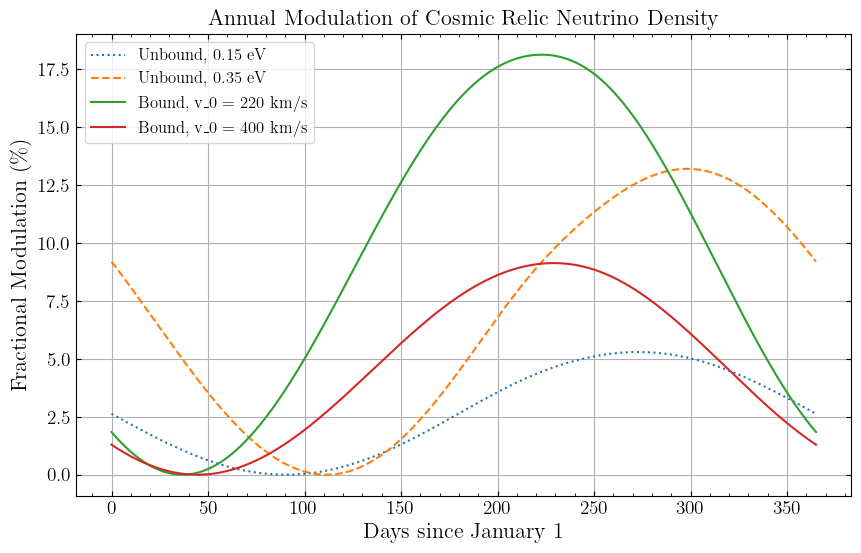

In [36]:
import datetime


### --------- ###
### Constants ###
### --------- ###


# Length of semi-major axis of Earth's orbit
a = 1.4960e8*Params.km  # (almost equal to Params.AU)

# Eccentricity of Earth's orbit
ecc = 0.016722

# Ecliptic longitude of the perihelion as in 2013
y_p = 102*Params.deg

# Earth's average orbital speed
v_earth = 29.79*Params.km/Params.s

# Angular frequency of Earth's orbit
omega = 2*Params.Pi/Params.yr

# Time of vernal equinox (in fraction of 1 year)
t_ve = 79/365.25*Params.yr

# Sun's velocity in CNB(==CMB) frame
v_CNB = jnp.array([-0.0695, -0.662, 0.747])*369*Params.km/Params.s

# Sun's velocity in Galactic frame
v_sun = jnp.array([11, 232, 7])*Params.km/Params.s

# Analytical expression for uniform CNB energy density, "far away from Sun"
rho_infty = Params.rho_0

# Unit vectors of ecliptic plane in Galactic coordinates as in 2013
eps1 = jnp.array([0.9940, 0.1095, 0.0031])
eps2 = jnp.array([-0.0517, 0.4945, -0.8677])


@jax.jit
def earth_vector(t):
    """
    Calculate Earth's position vector relative to the Sun at time t.
    Methodology from 1307.5323 and 1312.1355
    """

    # Phase since perihelion
    g_of_t = omega * (t - t_ve)

    # Approximation of "nu"-angle, which starts at perihelion then 
    # counterclockweise, see 1312.1355
    nu_angle = g_of_t + 2*ecc*jnp.sin(g_of_t) + 5/4*ecc**2*jnp.sin(2*g_of_t)

    # Distance from Sun to Earth at nu_angle
    r_of_t = a*(1-ecc**2)/(1+ecc*jnp.cos(nu_angle))

    # Ecliptic longitude
    y_of_t = y_p + nu_angle

    r_vec_of_t = r_of_t * (-eps1*jnp.sin(y_of_t) + eps2*jnp.cos(y_of_t))

    return r_vec_of_t


@jax.jit
def earth_velocity(t):
    """
    Calculate Earth's velocity relative to the Sun at time t.
    """

    # Phase since vernal equinox
    phase = omega * (t - t_ve)

    return v_earth * (eps1*jnp.cos(phase) + eps2*jnp.sin(phase))

# days = jnp.linspace(0, Params.yr, 365)
# earth_poss = jnp.array([earth_vector(day) for day in days])
# ic(earth_poss.shape)
# ic(jnp.linalg.norm(earth_poss, axis=-1).min()/(Params.AU))
# ic(jnp.linalg.norm(earth_poss, axis=-1).max()/(Params.AU))

# ic(earth_vels.shape)
# earth_vels = jnp.array([earth_velocity(day) for day in days])
# ic(jnp.linalg.norm(earth_vels, axis=-1).min()/(Params.km/Params.s))
# ic(jnp.linalg.norm(earth_vels, axis=-1).max()/(Params.km/Params.s))



@jax.jit
def v_infinity(v_s, r_s):
    """
    Calculate the initial Solar-frame velocity for a particle such that it has a velocity v_s at Earth's location: Eqn. (10) in Safdi+(2014).
    """

    # Approximate escape velocity of Sun's gravity
    v_GM = 2*Params.G*Params.Msun/jnp.linalg.norm(r_s)

    # Quantity $v_\infty^2$, and it's square root, i.e. quantity $v_\infty$
    v_inf2 = jnp.linalg.norm(v_s)**2 - v_GM
    v_inf = jnp.sqrt(jnp.maximum(0, v_inf2))  #? why (without max code breaks)
    # v_inf = jnp.sqrt(v_inf2)

    # Unit vector for Earth's position vector
    r_s_unit = r_s/jnp.linalg.norm(r_s)

    # Dot product of inputs v_s and unit vector of r_s
    vr_s_dot = jnp.dot(v_s, r_s_unit)

    # Equation (10)
    numer = v_inf2*v_s + v_inf*v_GM/2*r_s_unit - v_inf*v_s*vr_s_dot
    denom = v_inf2 + v_GM/2 - v_inf*vr_s_dot

    return numer/denom


@jax.jit
def g_earth(p, t, m_nu, bound, v_0):
    """Phase-space distribution at Earth's location."""

    # Convert momentum to velocity
    v_nu = p / m_nu

    # Earth's position vector that points from the Sun to the Earth
    r_s = earth_vector(t)

    v_s = v_nu + earth_velocity(t)
    v_inf = v_infinity(v_s, r_s)
    

    def v_nu_mag_greater_v_esc(_):
        f_of_v_nu = 1.
        return f_of_v_nu

    def v_nu_mag_smaller_v_esc(_):
        f_of_v_nu = 0.
        return f_of_v_nu


    f_of_v_nu = jax.lax.cond(
        jnp.all(jnp.abs(x_i) < snap_GRID_L),  # condition
        v_nu_mag_greater_v_esc,  # if condition == True
        v_nu_mag_smaller_v_esc,  # if condition == False
        None)


    return jax.lax.cond(
        bound,
        lambda: jnp.exp(-jnp.dot(v_inf - v_sun, v_inf - v_sun) / (2 * v_0**2)) / ((2 * Params.Pi * v_0**2)**1.5),
        lambda: Physics.Fermi_Dirac(
            jnp.linalg.norm(m_nu * v_inf - m_nu * v_CNB), Params())
    )


@jax.jit
def number_density(t, m_nu, bound, v_0):
    """Calculate the neutrino number density at time t."""
    p_min = 0.01 * Params.T_CNB
    p_max = 10 * Params.T_CNB
    p_range = jnp.linspace(p_min, p_max, 1000)
    
    integrand = 4 * Params.Pi * p_range**2 * jax.vmap(lambda p: g_earth(p, t, m_nu, bound, v_0))(p_range) / (2 * Params.Pi)**3
    
    return trap(integrand, p_range)

@jax.jit
def calculate_modulation(m_nu, bound, v_0):
    """Calculate the fractional modulation throughout the year."""
    days = jnp.linspace(0, Params.yr, 366)
    densities = jax.vmap(lambda t: number_density(t, m_nu, bound, v_0))(days)
    min_density = jnp.min(densities)
    return days, (densities - min_density) / (densities + min_density)

def plot_modulations_simple():
    """Plot the fractional modulations for different scenarios."""
    plt.figure(figsize=(10, 6))
    
    m_nu_light = 0.15 * Params.eV
    m_nu_heavy = 0.35 * Params.eV
    
    days, mod = calculate_modulation(m_nu_light, False, 220*Params.km/Params.s)
    plt.plot(days / Params.yr * 365, mod * 100, label='Unbound, 0.15 eV', linestyle='dotted')
    
    days, mod = calculate_modulation(m_nu_heavy, False, 220*Params.km/Params.s)
    plt.plot(days / Params.yr * 365, mod * 100, label='Unbound, 0.35 eV', linestyle='dashed')
    
    days, mod = calculate_modulation(m_nu_heavy, True, 220*Params.km/Params.s)
    plt.plot(days / Params.yr * 365, mod * 100, label='Bound, v_0 = 220 km/s', linestyle='solid')
    
    days, mod = calculate_modulation(m_nu_heavy, True, 400*Params.km/Params.s)
    plt.plot(days / Params.yr * 365, mod * 100, label='Bound, v_0 = 400 km/s', linestyle='solid')
    
    plt.xlabel('Days since January 1')
    plt.ylabel(r'Fractional Modulation ($\%$)')
    plt.title('Annual Modulation of Cosmic Relic Neutrino Density')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_modulations_new(start_date_str='09-11'):
    """Plot the fractional modulations for different scenarios with specific styling."""
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()
    ax = fig.add_subplot(111)

    # Convert start_date_str to datetime object
    start_date = datetime.datetime.strptime(start_date_str, '%m-%d')
    
    # Calculate the day of the year for the start date
    start_day_of_year = start_date.timetuple().tm_yday

    # Generate data
    m_nu_light = 0.15 * Params.eV
    m_nu_heavy = 0.35 * Params.eV
    
    scenarios = [
        (m_nu_light, False, 220*Params.km/Params.s, "hotpink", "Unbound, 0.15 eV"),
        (m_nu_heavy, False, 220*Params.km/Params.s, "mediumvioletred", "Unbound, 0.35 eV"),
        (m_nu_heavy, True, 220*Params.km/Params.s, "blueviolet", "Bound, v_0 = 220 km/s"),
        (m_nu_heavy, True, 400*Params.km/Params.s, "rebeccapurple", "Bound, v_0 = 400 km/s")
    ]

    for m_nu, bound, v_0, color, label in scenarios:
        days, mod = calculate_modulation(m_nu, bound, v_0)
        
        # Shift days to start from the specified date
        shifted_days = (days / Params.yr * 365 - start_day_of_year) % 365 + 1
        sorted_indices = jnp.argsort(shifted_days)
        shifted_days = shifted_days[sorted_indices]
        mod = mod[sorted_indices]

        ax.plot(shifted_days, mod * 100, 'o-', color=color, label=label)

    # Calculate tick positions and labels
    tick_dates = [datetime.date(2000, 11, 1), datetime.date(2000, 2, 1), 
                  datetime.date(2000, 5, 1), datetime.date(2000, 8, 1)]
    tick_days = [(date - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1 
                 for date in tick_dates]
    tick_labels = ['Nov 1', 'Feb 1', 'May 1', 'Aug 1']

    plt.xticks(tick_days, tick_labels)

    # Set axis limits
    plt.ylim(0, 3)  # Adjusted based on the expected range of modulation

    plt.title("Annual Modulation of Cosmic Relic Neutrino Density")
    plt.ylabel(r'Modulation ($\%$)')
    plt.grid(True, which="major", linestyle="dashed")

    # Add vertical lines for March 12th and September 11th
    march_12 = (datetime.date(2000, 3, 12) - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1
    sept_11 = (datetime.date(2000, 9, 11) - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1
    plt.axvline(x=march_12, color='r', linestyle=':', label='March 12th')
    plt.axvline(x=sept_11, color='g', linestyle=':', label='September 11th')

    plt.legend(prop={"size":12})

    plt.savefig(
        f"modulation_1year_Earth_frame_{start_date_str}start_FD.pdf",
        bbox_inches="tight")

    plt.show()
    plt.close()

# Run the main function to generate the plot
# plot_modulations_simple()

## Annual modulation: Single halo

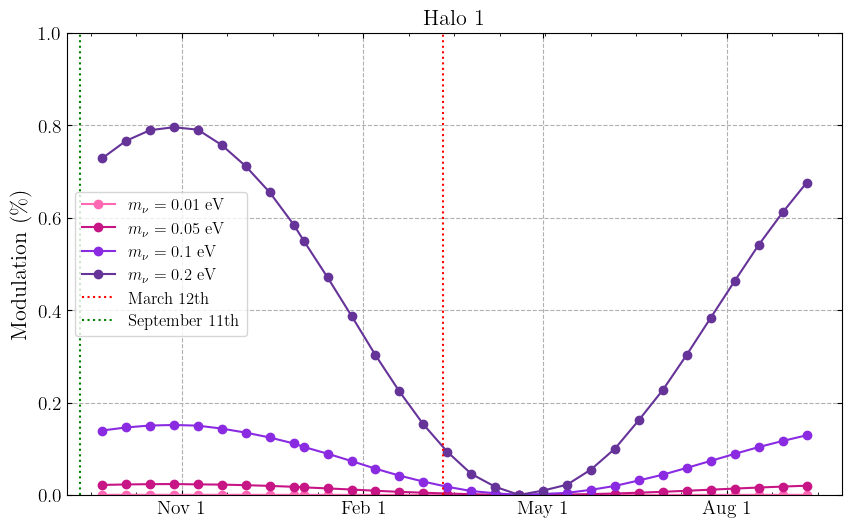

In [25]:
import datetime
def modulation_1halo(
        nu_dens_days, simulated_days, halo_i, start_date_str='09-11'):

    fig = plt.figure(figsize =(10, 6))
    fig.tight_layout()
    ax = fig.add_subplot(111)

    # Convert start_date_str to datetime object
    start_date = datetime.datetime.strptime(start_date_str, '%m-%d')
    
    # Calculate the day of the year for the start date
    start_day_of_year = start_date.timetuple().tm_yday

    # Shift days to start from the specified date
    shifted_days = (simulated_days - start_day_of_year) % 365 + 1
    sorted_indices = jnp.argsort(shifted_days)
    shifted_days = shifted_days[sorted_indices]

    # Adjust vertical lines for March 12th and September 11th
    march_12 = (datetime.date(2000, 3, 12) - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1
    sept_11 = (datetime.date(2000, 9, 11) - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1

    violet_colors = [
        "hotpink", 
        "mediumvioletred", 
        "blueviolet",
        "rebeccapurple",
    ]

    for m_idx, (m_val, color) in enumerate(zip(nu_m_picks[:4], violet_colors)):

        nu_dens_m = nu_dens_days[:, m_idx]

        # Compute fractional modulation
        nu_min = jnp.min(nu_dens_m)
        mod = (nu_dens_m - nu_min) / (nu_dens_m + nu_min) * 100
        mod = mod[sorted_indices]

        ax.plot(shifted_days, mod, 'o-', color=color, label=fr"$m_\nu = {m_val}$ eV")

    # Calculate tick positions and labels
    tick_dates = [datetime.date(2000, 11, 1), datetime.date(2000, 2, 1), 
                  datetime.date(2000, 5, 1), datetime.date(2000, 8, 1)]
    tick_days = [(date - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1 
                 for date in tick_dates]
    tick_labels = ['Nov 1', 'Feb 1', 'May 1', 'Aug 1']

    plt.xticks(tick_days, tick_labels)

    # Set x-axis limits
    # plt.xlim(1, 365)
    plt.ylim(0, 1)

    plt.title(f"Halo {halo_i+1}")
    plt.ylabel(r'Modulation ($\%$)')
    plt.grid(True, which="major", linestyle="dashed")

    plt.axvline(x=march_12, color='r', linestyle=':', label='March 12th')
    plt.axvline(x=sept_11, color='g', linestyle=':', label='September 11th')

    plt.legend(prop={"size":12})

    # plt.savefig(
    #     f"{fig_folder}/modulation_1year_Earth_frame_{start_date_str}start.pdf",
    #     bbox_inches="tight")
    plt.savefig(
        f"{fig_folder}/modulation_1year_Earth_frame_{start_date_str}start_FD.pdf",
        bbox_inches="tight")

    plt.show()
    plt.close()


# Load number densities and associated days arrays
# n_nu_days = jnp.load(f"{sim_folder}/n_nu_days_Earth_frame.npy")
# days_nrs = jnp.load(f"{sim_folder}/days_nrs_Earth_frame.npy")
# ic(n_nu_days.shape)

# for hi in (0,1,4,5):
#     modulation_1halo(
#         nu_dens_days=n_nu_days[:,hi,:]/Params.N0_cm3, 
#         simulated_days=days_nrs, halo_i=hi, start_date_str="09-11")


n_nu_days_FD = jnp.load(f"{sim_folder}/n_nu_days_Earth_frame_FD.npy")
days_nrs_FD = jnp.load(f"{sim_folder}/days_nrs_Earth_frame_FD.npy")
modulation_1halo(
    nu_dens_days=n_nu_days_FD[:,0,:]/Params.N0_cm3, halo_i=0,
    simulated_days=days_nrs_FD, start_date_str="09-11")

## Annual modulation: Halo band

n_nu_days shape: (31, 6, 5)


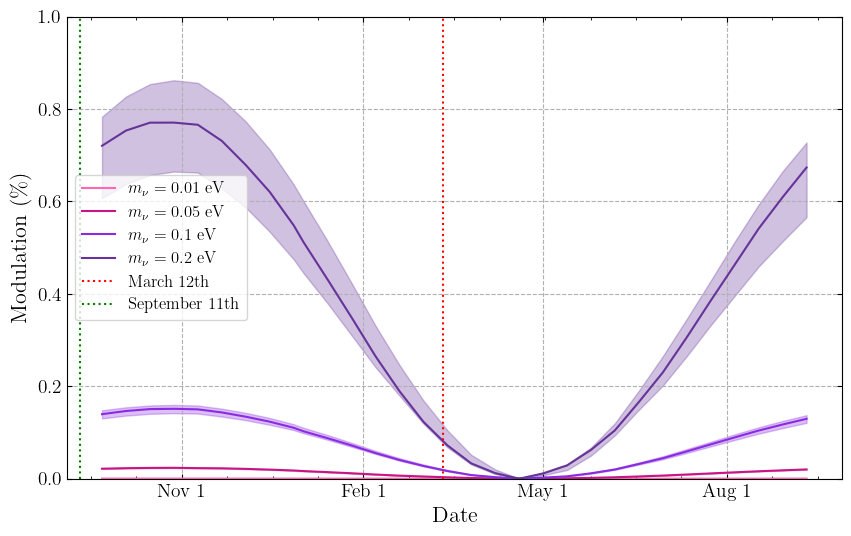

In [21]:
def modulation_band(nu_dens_days, simulated_days, nu_m_picks, start_date_str='09-11'):
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()
    ax = fig.add_subplot(111)

    # Convert start_date_str to datetime object
    start_date = datetime.datetime.strptime(start_date_str, '%m-%d')
    
    # Calculate the day of the year for the start date
    start_day_of_year = start_date.timetuple().tm_yday

    # Shift days to start from the specified date
    shifted_days = (simulated_days - start_day_of_year) % 365 + 1
    sorted_indices = jnp.argsort(shifted_days)
    shifted_days = shifted_days[sorted_indices]

    # Adjust vertical lines for March 12th and September 11th
    march_12 = (datetime.date(2000, 3, 12) - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1
    sept_11 = (datetime.date(2000, 9, 11) - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1

    violet_colors = [
        "hotpink", 
        "mediumvioletred", 
        "blueviolet",
        "rebeccapurple",
    ]

    for m_idx, (m_val, color) in enumerate(zip(nu_m_picks[:4], violet_colors)):
        nu_dens_m = nu_dens_days[:, :, m_idx]  # (days, halos)

        # Compute fractional modulation for each halo
        nu_min = jnp.min(nu_dens_m, axis=0)
        mod = (nu_dens_m - nu_min) / (nu_dens_m + nu_min) * 100

        # Sort modulation values for each day
        mod_sorted = jnp.sort(mod, axis=1)

        # Compute median and 1-sigma band
        median = jnp.median(mod_sorted, axis=1)
        lower = jnp.percentile(mod_sorted, 16, axis=1)
        upper = jnp.percentile(mod_sorted, 84, axis=1)

        # Apply sorting to match shifted_days
        median = median[sorted_indices]
        lower = lower[sorted_indices]
        upper = upper[sorted_indices]

        # Plot median and 1-sigma band
        ax.plot(shifted_days, median, '-', color=color, label=fr"$m_\nu = {m_val}$ eV")
        ax.fill_between(shifted_days, lower, upper, color=color, alpha=0.3)

    # Calculate tick positions and labels
    tick_dates = [datetime.date(2000, 11, 1), datetime.date(2000, 2, 1), 
                  datetime.date(2000, 5, 1), datetime.date(2000, 8, 1)]
    tick_days = [(date - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1 
                 for date in tick_dates]
    tick_labels = ['Nov 1', 'Feb 1', 'May 1', 'Aug 1']

    plt.xticks(tick_days, tick_labels)

    # Set axis limits and labels
    plt.ylim(0, 1)
    plt.ylabel(r'Modulation ($\%$)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True, which="major", linestyle="dashed")

    plt.axvline(x=march_12, color='r', linestyle=':', label='March 12th')
    plt.axvline(x=sept_11, color='g', linestyle=':', label='September 11th')

    plt.legend(prop={"size":12})

    plt.savefig(
        f"{fig_folder}/modulation_1year_Earth_frame_{start_date_str}start_band.pdf",
        bbox_inches="tight")

    plt.show()
    plt.close()

# Load number densities and associated days arrays
n_nu_days = jnp.load(f"{sim_folder}/n_nu_days_Earth_frame.npy")
days_nrs = jnp.load(f"{sim_folder}/days_nrs_Earth_frame.npy")
print(f"n_nu_days shape: {n_nu_days.shape}")

# Call the modulation function with the full n_nu_days array
modulation_band(
    nu_dens_days=n_nu_days/Params.N0_cm3, 
    simulated_days=days_nrs, 
    nu_m_picks=nu_m_picks,
    start_date_str="09-11")